# Table of Contents
 <p><div class="lev1 toc-item"><a href="#はじめに" data-toc-modified-id="はじめに-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>はじめに</a></div><div class="lev2 toc-item"><a href="#概要" data-toc-modified-id="概要-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>概要</a></div><div class="lev2 toc-item"><a href="#実行環境" data-toc-modified-id="実行環境-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>実行環境</a></div><div class="lev1 toc-item"><a href="#Graphillionの方向性wrapper" data-toc-modified-id="Graphillionの方向性wrapper-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Graphillionの方向性wrapper</a></div><div class="lev2 toc-item"><a href="#Graphillionとリンク" data-toc-modified-id="Graphillionとリンク-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Graphillionとリンク</a></div><div class="lev2 toc-item"><a href="#仮想ノードの追加" data-toc-modified-id="仮想ノードの追加-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>仮想ノードの追加</a></div><div class="lev2 toc-item"><a href="#不要なサブグラフの削除" data-toc-modified-id="不要なサブグラフの削除-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>不要なサブグラフの削除</a></div><div class="lev1 toc-item"><a href="#簡単なグラフへの適用" data-toc-modified-id="簡単なグラフへの適用-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>簡単なグラフへの適用</a></div><div class="lev2 toc-item"><a href="#仮想ノード追加" data-toc-modified-id="仮想ノード追加-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>仮想ノード追加</a></div><div class="lev2 toc-item"><a href="#サブグラフ削除-rule1" data-toc-modified-id="サブグラフ削除-rule1-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>サブグラフ削除 rule1</a></div><div class="lev2 toc-item"><a href="#サブグラフ削除-rule2" data-toc-modified-id="サブグラフ削除-rule2-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>サブグラフ削除 rule2</a></div>

# はじめに

## 概要

グラフに仮想的なノードを追加してGraphillionで双方向リンクを考慮したパス列挙を可能にするラッパーライブラリの動作原理の解説を行う．  
スクリプトを動かして動作原理を解説するセルでは記述を簡単にするためにnetworkxの機能を使用しているが，ラッパーの実装には用いていないので注意．

## 実行環境

Python 3系  

ライブラリ  

* networkx(描画の見た目を考慮すると1.5.xが望ましいが，それより高いバージョンでも動くはず)
* Graphillion(1.0)

# Graphillionの方向性wrapper

## Graphillionとリンク

リンク(i,j)にコスト100，リンク(j,i)にコスト200が設定されているグラフがあるとする．これを辺のリストで表せば`[(i,j,100), (j,i,200)]`となるが，Graphillionに読み込ませると`KeyError`の例外が送出されてしまう．これはGraphillionが有向性を持たないため，構成ノードは同じだが方向性の異なるリンクを区別できないという特徴によるものである．

## 仮想ノードの追加

先ほど例に挙げたようなグラフを扱えるようにするために，グラフに仮想的なノードを追加し，構成ノードが重複しないような辺のリストを作成する．仮想ノードの追加は以下のように行う．

* **リンク(i,j,w1)に対して**  
仮想ノードを設けずに元のリンクを使用する

* **リンク(j,i,w2)に対して**  
仮想ノードjiを設ける  
リンク(j,ji,w2),(ji,i,0)を追加する

したがって，元のグラフのノード数を$n$，リンク数を$l$とすると，仮想ノード追加後のグラフのノード数は$n+l$，リンク数は$3l$となる．

以下にリンク(1,2)，(2,3)から構成されるグラフに仮想ノードを追加したグラフを示す．

<img src="example_original.png" alt="" title="" width="300" height="200" />
<div style="text-align: center;">
図1.1 元のグラフ
</div>

<img src="example_virtual_nodes.png" alt="" title="" width="300" height="200" />
<div style="text-align: center;">
図1.2 仮想ノード追加後のグラフ
</div>

このように仮想ノードを追加することで仮想的にリンク(i,j)と(j,i)を作り出すことができる．リンクはいずれも構成ノードが異なるのでGraphillionで読み込んでも`KeyError`が発生することはない．

## 不要なサブグラフの削除

仮想ノードを追加することで双方向リンクをもつ辺のリストをGraphillionに読み込ませることができるようになる．しかし，仮想ノードを追加したグラフに対してパス列挙を行うと方向性を守らない不適切な結果も出現してしまう．  
例えば，図1.1のグラフでノード1からノード3へのパスを求めると`[(1,2),(2,3]`の1本しか存在しないが，仮想ノード追加後のグラフでは正しいパスの他にも3本のパスが発生してしまう．このような不要なパスを取り除くために`Graphillion.excludiing`を使用して不要なサブグラフを削除する．削除のルールは以下の通り．

* **rule1**  
スタートノードへの流入リンクをすべて削除

* **rule2**  
スタートノード，ターゲットノード以外のノードで流入リンクの次数が2以上のノードについて，そのノードの流入リンク2本からなるサブグラフをすべて削除  
あるノードの流入リンクの本数を$n$とすると削除するサブグラフは${}_{n}\mathrm{C}_{2}$個存在する．

この2つルールを図1.2のグラフに適用した様子をrule1を赤色，rule2を青色として図示すると以下のようになる．

<img src="example_excluding.png" alt="" title="" width="300" height="200" />
<div style="text-align: center;">
図1.3 仮想ノード追加後のグラフ
</div>

まず，rule1によって1から21を経由して2へ至るパスが削除され，1から直接2へ行くパスが残る．次にrule2によってサブグラフ`[(1,2), (32,2)]`が削除されるのでリンク(1,2)と(32,2)は同時に使用できなくなる．すると，2から3へ至る経路はリンク(2,3)を使用するものしか残らない．以上の操作により方向性を守ったパス`[(1,2),(2,3)]`が得られる．

In [83]:
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

from graphillion import GraphSet

%matplotlib inline

# 簡単なグラフへの適用

以下に示すG(4, 5)に仮想ノードを追加して，ノード1からノード4への方向性を考慮したパス列挙を行う．  
簡単のためにリンクコストの設定は行わない．

In [84]:
def draw(G, pos, subgraph=None):
    nx.draw_networkx_nodes(G, pos, node_color="w")
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)
    if subgraph is not None:
        subgraph = nx.DiGraph(data=subgraph)
        nx.draw_networkx_nodes(subgraph, pos, node_color="r")
        nx.draw_networkx_labels(subgraph, pos)
        nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), edge_color="r")
    plt.xticks([])
    plt.yticks([])
    plt.show()

[('1', '2'), ('1', '3'), ('2', '3'), ('2', '4'), ('3', '4')]


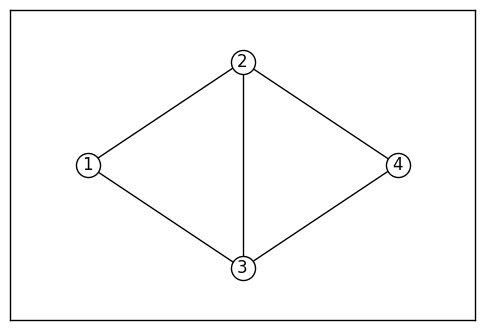

In [85]:
edgelist = [("1","2"),("1","3"),("2","3"),("2","4"),("3","4")]
G = nx.Graph(data=edgelist)
node_pos = {"1": (0,0), "2": (1,1), "3": (1,-1), "4": (2,0)}
print(G.edges())
draw(G, node_pos)

## 仮想ノード追加

仮想ノードを追加したグラフを作成する．  
方向性を分かりやすくするために有向グラフとして描画する．

[('1', '2'), ('1', '3'), ('2', '21'), ('2', '3'), ('2', '4'), ('21', '1'), ('3', '31'), ('3', '32'), ('3', '4'), ('31', '1'), ('32', '2'), ('4', '42'), ('4', '43'), ('42', '2'), ('43', '3')]


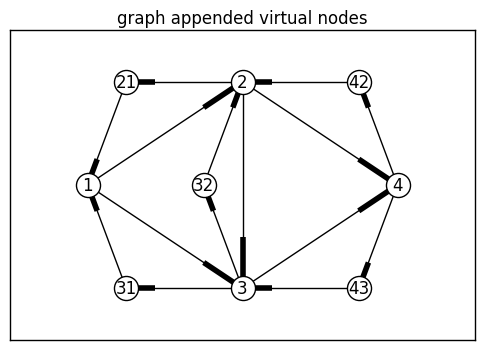

In [86]:
bidirectional_G = nx.DiGraph()
bidirectional_G.add_edges_from([("1", "2"), ("2","21"), ("21","1"), ("1", "3"), ("3","31"), ("31","1"), ("2", "3"), ("3","32"), ("32","2"),
                    ("2", "4"), ("4","42"), ("42","2"), ("3", "4"), ("4","43"), ("43","3")])
node_pos = {"1": (0,0), "2": (1,1), "3": (1,-1), "4": (2,0), "21": (0.25,1),  "31": (0.25,-1),
            "23": (1,0), "32": (0.75,0), "42": (1.75,1), "43": (1.75,-1)}
print(bidirectional_G.edges())
plt.title("graph appended virtual nodes")
draw(bidirectional_G, node_pos)

ユニバースを定義

In [87]:
GraphSet.set_universe(bidirectional_G.edges())

1から4への方向性を無視したすべてのパスを求める

方向性を無視した1から4へのパスの総数 24


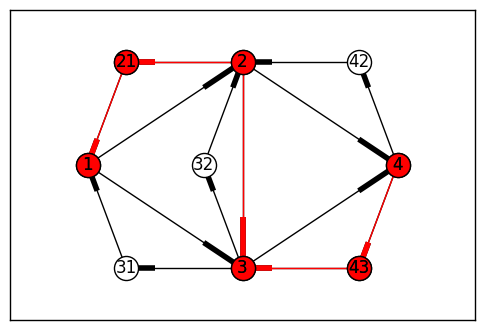

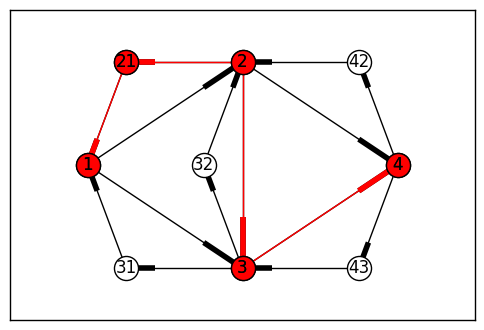

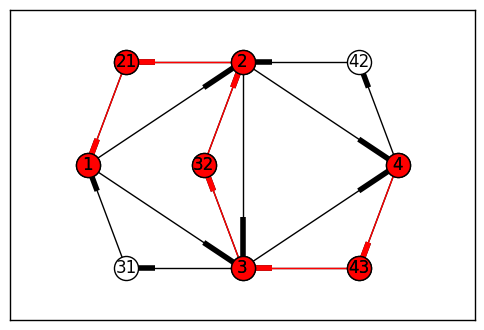

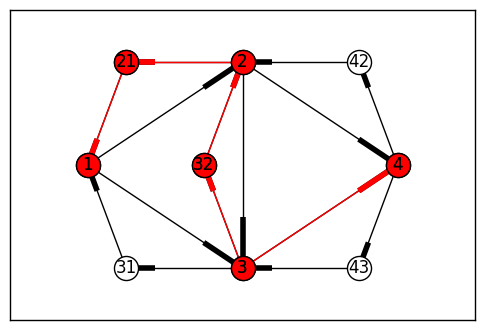

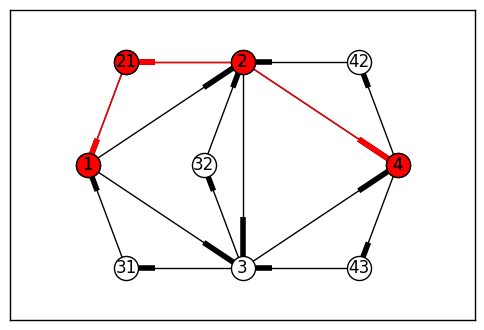

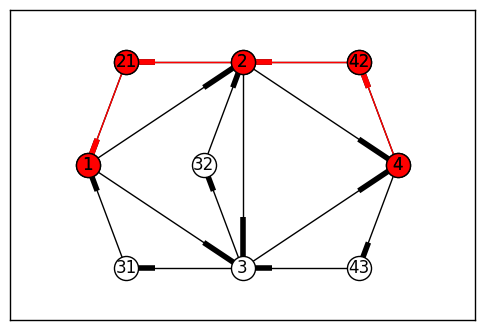

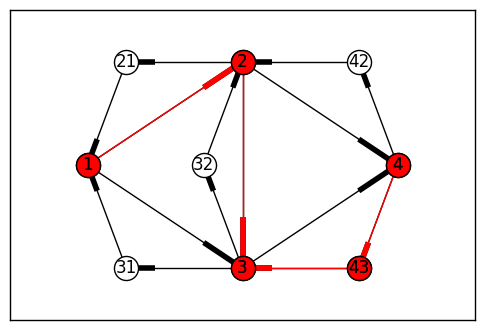

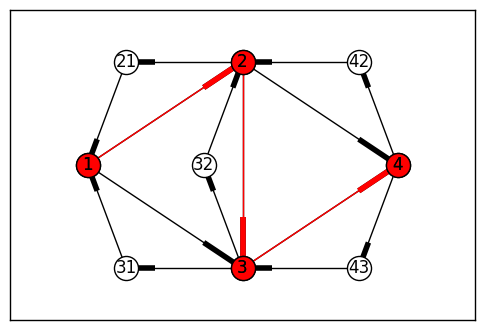

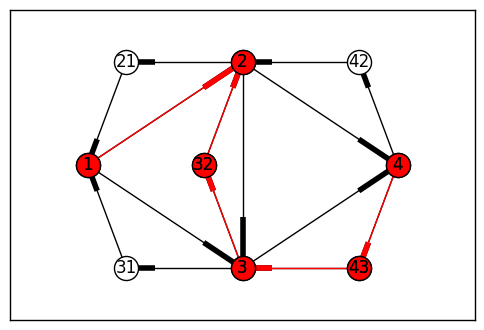

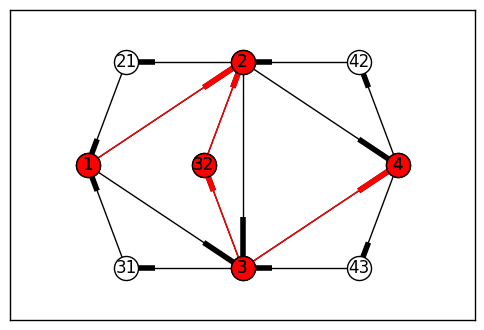

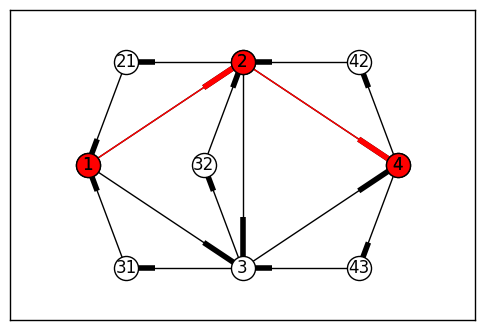

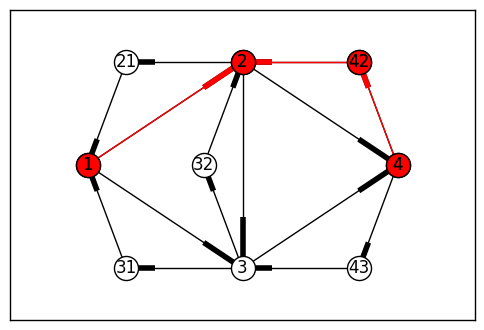

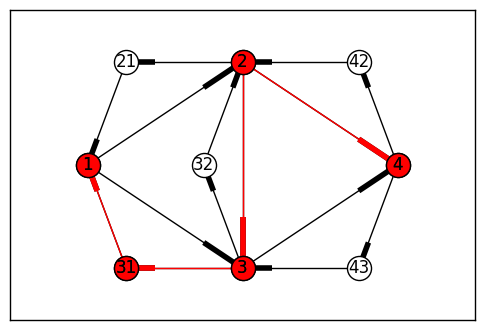

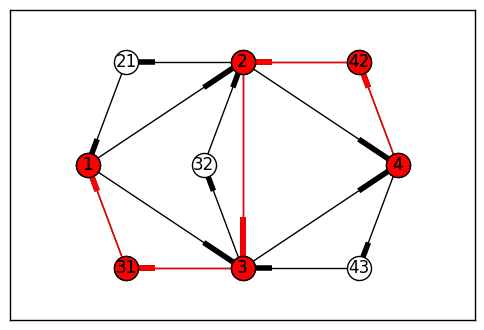

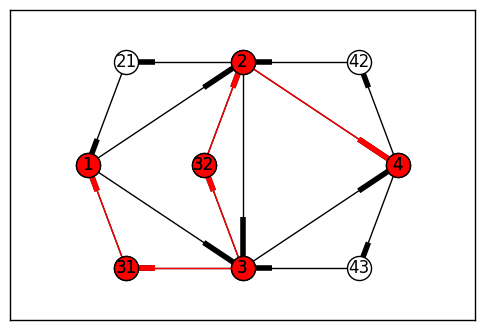

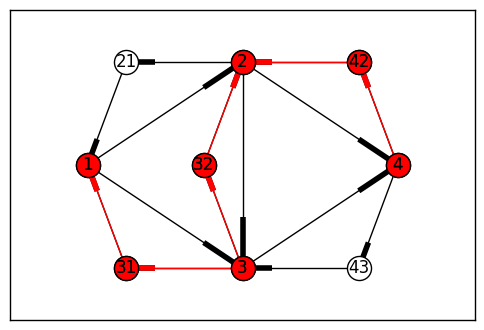

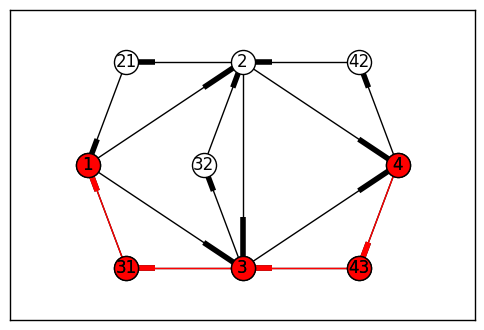

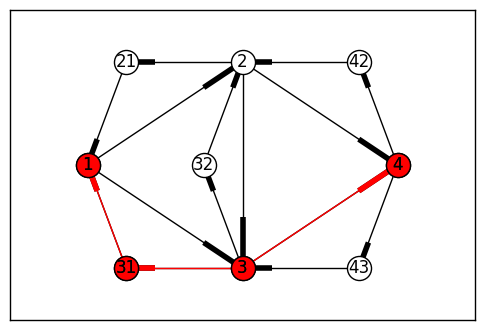

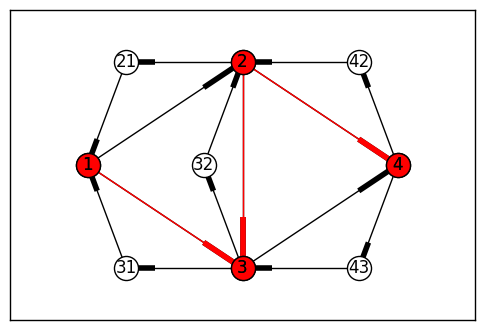

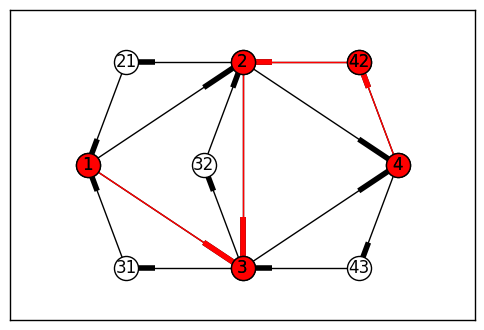

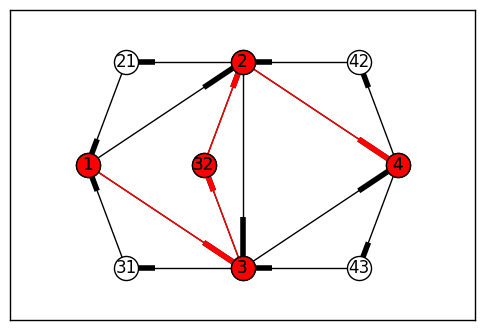

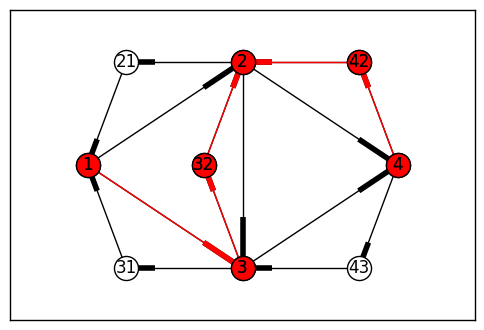

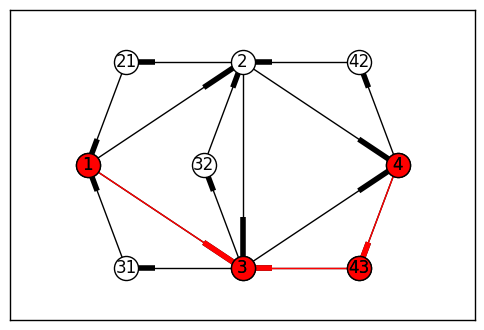

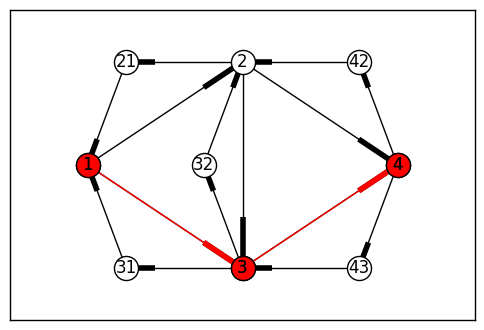

In [88]:
paths_1_4 = GraphSet.paths("1", "4")
print("方向性を無視した1から4へのパスの総数", len(paths_1_4))
for path in paths_1_4:
    # draw(nx.DiGraph(data=path), node_pos)
    draw(bidirectional_G, node_pos, subgraph=path)

## サブグラフ削除 rule1

スタートノード1へ流入するリンクをすべて削除する．

スタートノード1へ流入するリンク


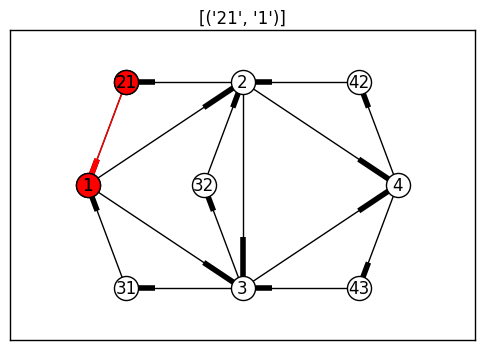

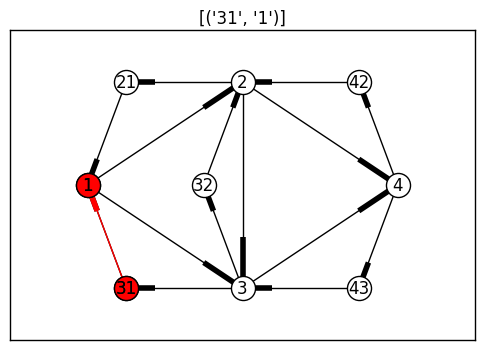

In [89]:
internal_links = [[(predecessor, "1")] for predecessor in bidirectional_G.predecessors_iter("1")]
print("スタートノード1へ流入するリンク")
for internal_link in internal_links:
    plt.title(internal_link)
    draw(bidirectional_G, node_pos, subgraph=internal_link)

rule1を適用したパス集合を描画する


rule1を適用したパス集合


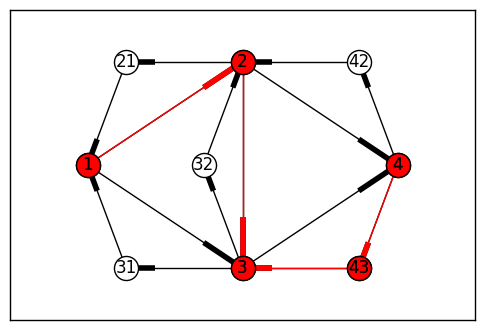

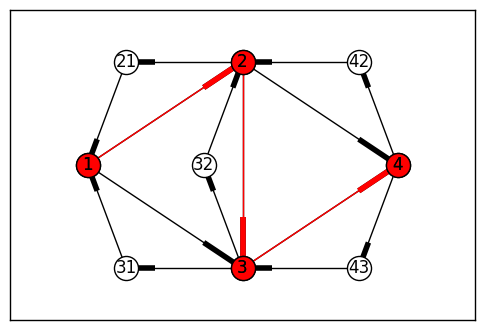

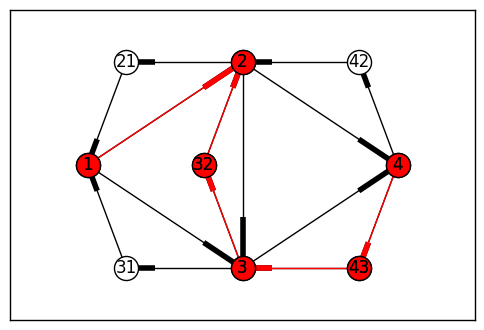

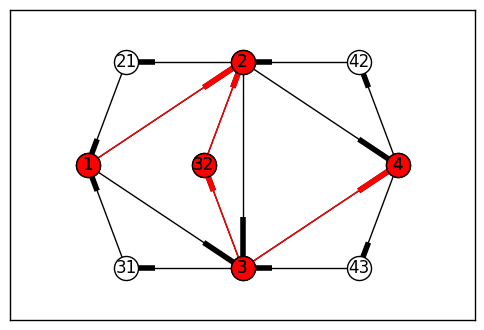

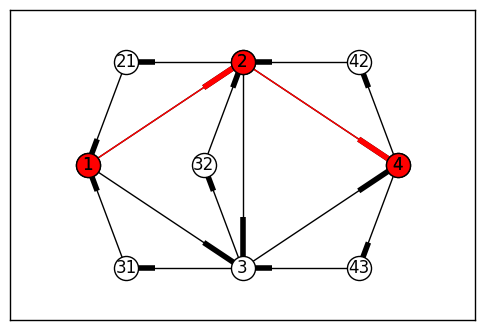

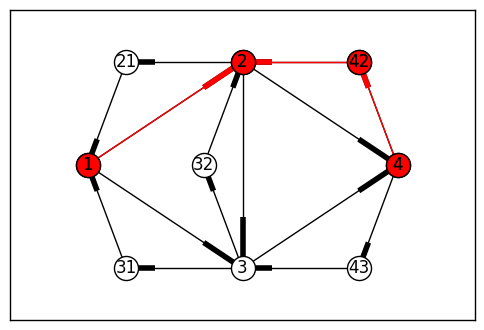

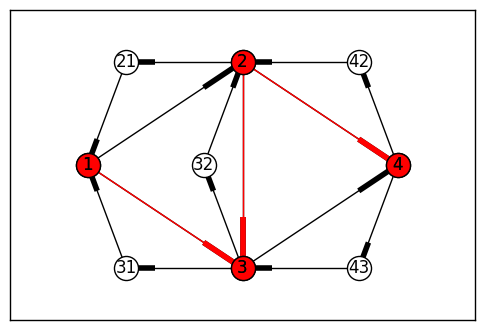

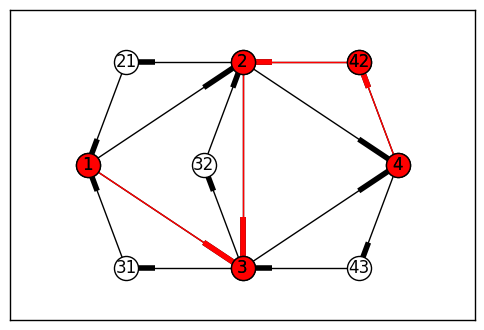

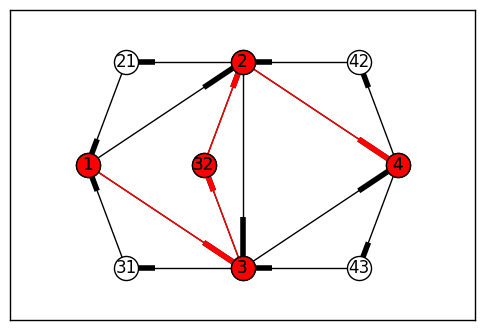

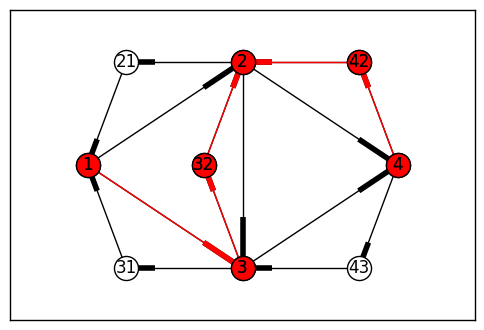

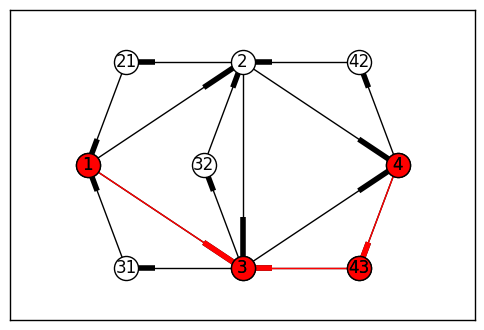

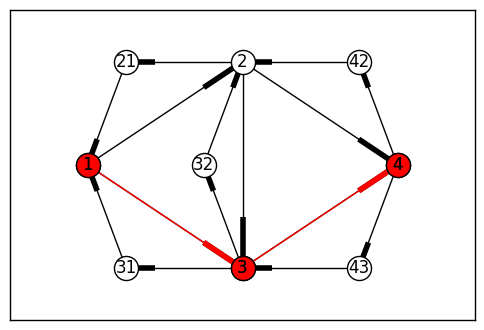

In [90]:
rule1 = GraphSet(internal_links)
paths_1_4 = paths_1_4.excluding(rule1)
print("\nrule1を適用したパス集合")
for path in paths_1_4:
    # draw(nx.DiGraph(data=path), node_pos)
    draw(bidirectional_G, node_pos, subgraph=path)

## サブグラフ削除 rule2

スタートノード，ターゲットノード以外のノードで流入リンクの次数が2以上のノードについて，そのノードの流入リンク2本から構成されるサブグラフをすべて削除する．  
該当するノードは2と3．

ノード2のサブグラフ

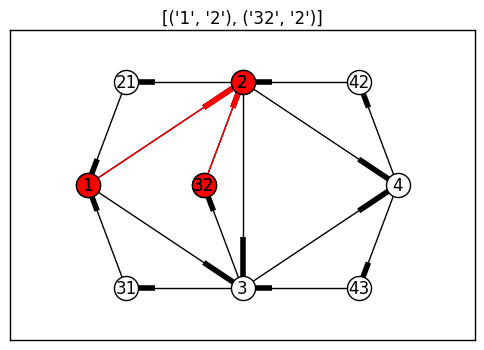

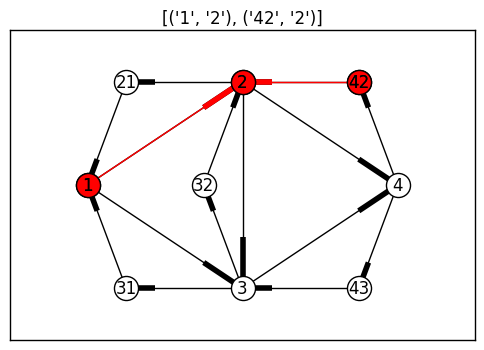

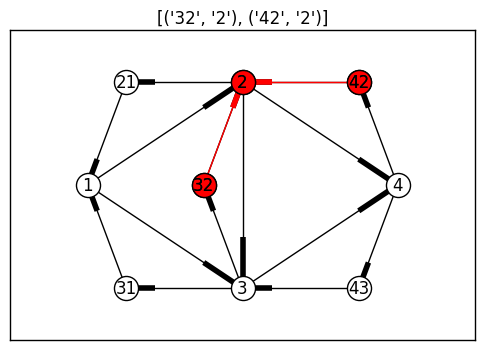

In [91]:
node2_internal_links = [(predecessor, "2") for predecessor in bidirectional_G.predecessors_iter("2")]
rule2_node2 = [[link1, link2] for link1,link2 in combinations(node2_internal_links, 2)]
rule2_node2 = GraphSet(rule2_node2)
paths_1_4 = paths_1_4.excluding(rule2_node2)

for subgraph in rule2_node2:
    plt.title(subgraph)
    draw(bidirectional_G, node_pos, subgraph=subgraph)

ノード3のサブグラフ

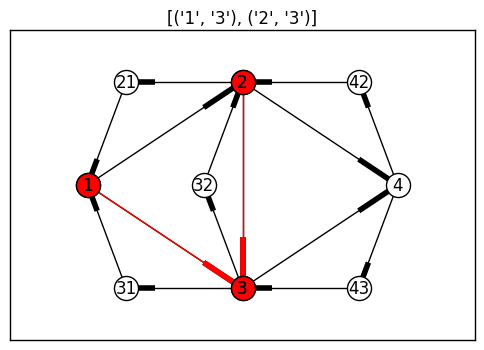

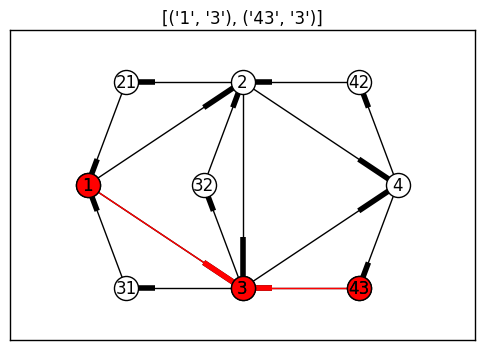

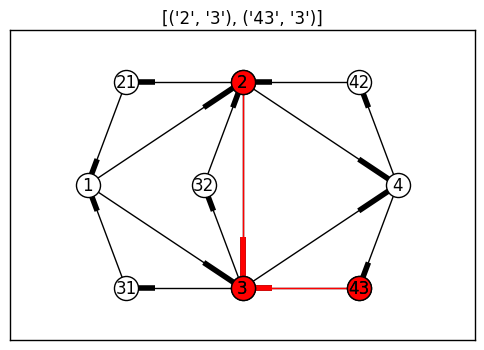

In [92]:
node3_internal_links = [(predecessor, "3") for predecessor in bidirectional_G.predecessors_iter("3")]
rule2_node3 = [[link1, link2] for link1,link2 in combinations(node3_internal_links, 2)]
rule2_node3 = GraphSet(rule2_node3)
paths_1_4 = paths_1_4.excluding(rule2_node3)

for subgraph in rule2_node3:
    plt.title(subgraph)
    draw(bidirectional_G, node_pos, subgraph=subgraph)

rule2を適用したパス集合を描画する．  
方向性を守ったパスだけが残っていることが確認できる．

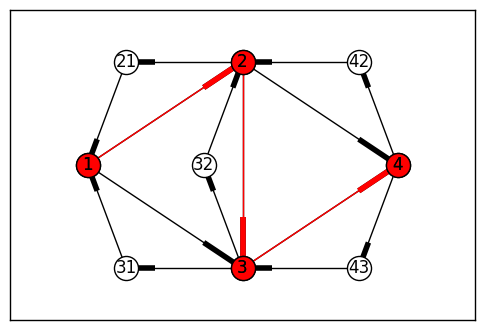

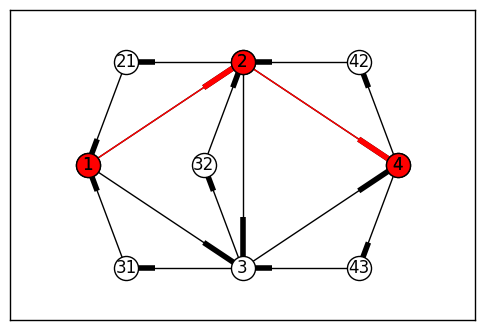

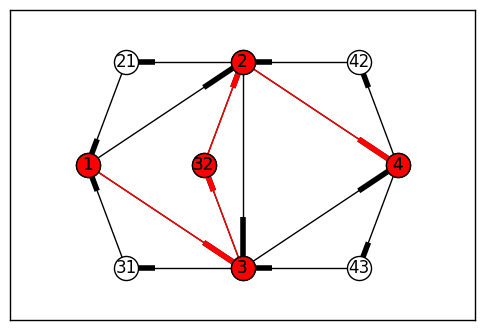

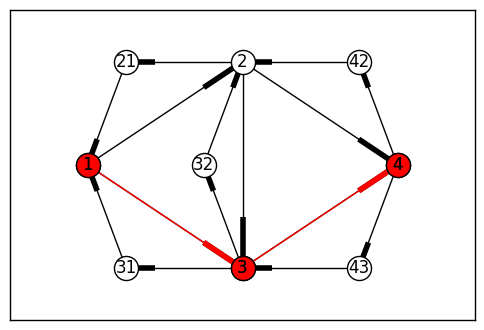

In [93]:
for path in paths_1_4:
    draw(bidirectional_G, node_pos, subgraph=path)